# アミノ酸配列のグラフ表示画像のVision Transformerによるタンパク質ファミリー分類（5分割交差検証）
- グラデーション適用
- クラスごとに分ける `StratifiedKFold` を採用
- ベースモデル：`openai/clip-vit-base-patch16`
- ハイパーパラメータ
    - バッチサイズ：$16$
    - エポック数：$20$
    - 学習率：$5 \times 10^{-5}$

## 1. ライブラリのインポート

In [23]:
from torch.utils.data import Dataset, Subset
from PIL import Image
import os
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import CLIPImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

label2id = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
id2label = {v: k for k, v in label2id.items()}

MODEL_NAME = "openai/clip-vit-base-patch16"
BATCH_SIZE = 16
EPOCHS = 20
LR = 5e-5
# WEIGHT_DECAY = 1e-4

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [24]:
class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "label": label}

## 2. 画像前処理（ViT用）

In [25]:
processor = CLIPImageProcessor.from_pretrained(MODEL_NAME)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. `Trainer` を使って学習

In [26]:
accuracy = evaluate.load("accuracy")
dataset = GPCRImageDataset("../gpcr_labels.csv", "../graphs/gradation", transform=transform)

# StratifiedKFoldはラベル情報を使う
labels = dataset.data["label"].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[Fold 1 / 5]


Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_46604\2173838874.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.679226,0.783679,0.324992,0.285015,0.289990
2,0.780400,0.561883,0.834197,0.344457,0.322225,0.326687
3,0.512400,0.536643,0.849093,0.477297,0.395231,0.423368
4,0.373400,0.448706,0.879534,0.504454,0.446737,0.469630
5,0.373400,0.575120,0.889896,0.495884,0.465567,0.476597
6,0.284300,0.396694,0.900259,0.537832,0.479080,0.500921
7,0.211200,0.410250,0.906088,0.596961,0.561437,0.569389
8,0.176900,0.553456,0.887306,0.512934,0.476538,0.491067
9,0.176900,0.474339,0.920984,0.532800,0.504921,0.517435
10,0.147500,0.581384,0.909326,0.718544,0.599851,0.641220


Accuracy: 0.9268 | Precision: 0.7431 | Recall: 0.7175 | F1: 0.7294
              precision    recall  f1-score      support
A              0.935572  0.971725  0.953306  1061.000000
B              0.864198  0.769231  0.813953    91.000000
C              0.915730  0.846753  0.879892   385.000000
D              0.000000  0.000000  0.000000     3.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.926813  0.926813  0.926813     0.926813
macro avg      0.743100  0.717542  0.729430  1544.000000
weighted avg   0.924767  0.926813  0.925055  1544.000000


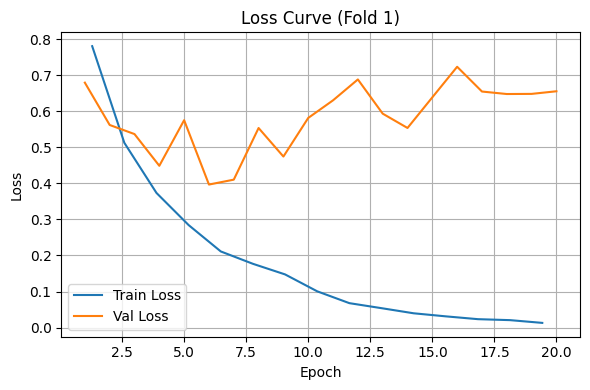

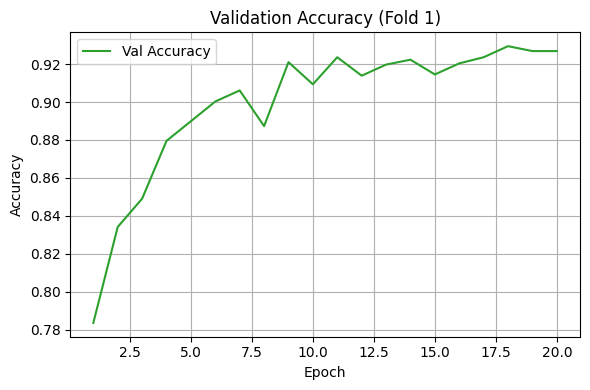

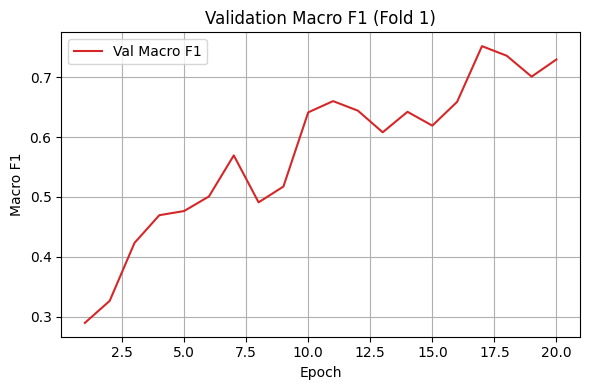

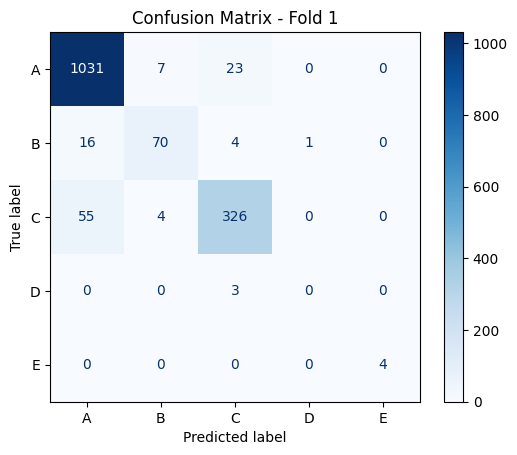

[Fold 2 / 5]


Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_46604\2173838874.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.749887,0.729099,0.276727,0.245027,0.241352
2,0.836400,0.615892,0.800389,0.310357,0.306967,0.305863
3,0.634300,0.529843,0.815943,0.472711,0.338209,0.367903
4,0.463600,0.454568,0.859365,0.336158,0.348513,0.341834
5,0.463600,0.407402,0.877511,0.495066,0.446348,0.460658
6,0.313100,0.387712,0.902139,0.512087,0.469948,0.487776
7,0.227500,0.461800,0.906027,0.503474,0.478331,0.488840
8,0.173100,0.612421,0.899546,0.617953,0.613750,0.614841
9,0.173100,0.454469,0.917693,0.601732,0.621385,0.608514
10,0.126400,0.462159,0.909268,0.568378,0.631305,0.592337


Accuracy: 0.9274 | Precision: 0.7823 | Recall: 0.7586 | F1: 0.7606
              precision    recall  f1-score      support
A              0.941765  0.975495  0.958333  1061.000000
B              0.808824  0.611111  0.696203    90.000000
C              0.910811  0.873057  0.891534   386.000000
D              0.500000  0.333333  0.400000     3.000000
E              0.750000  1.000000  0.857143     3.000000
accuracy       0.927414  0.927414  0.927414     0.927414
macro avg      0.782280  0.758599  0.760643  1543.000000
weighted avg   0.925036  0.927414  0.925051  1543.000000


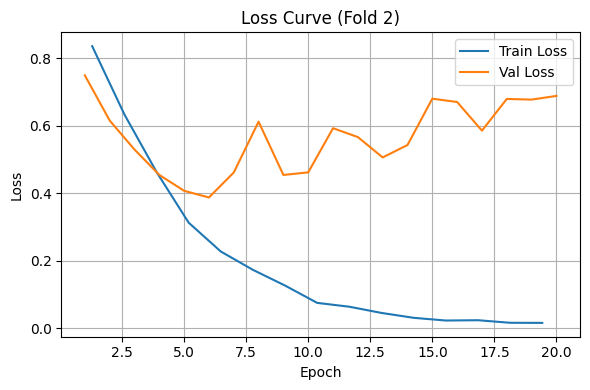

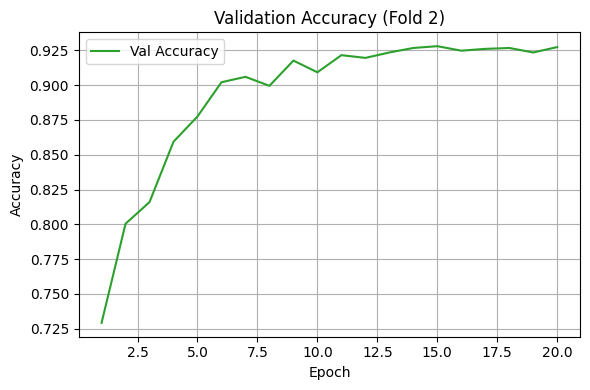

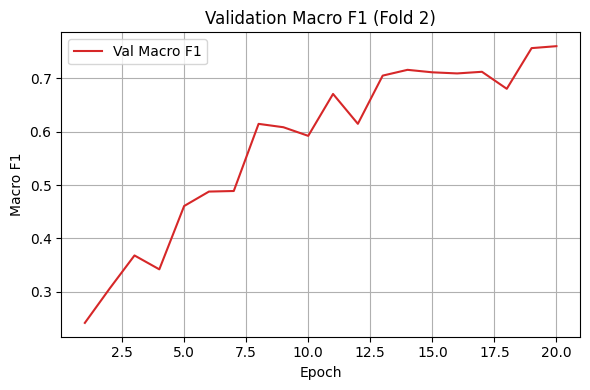

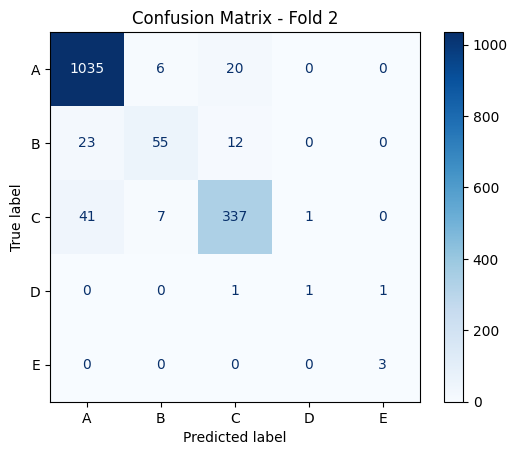

[Fold 3 / 5]


Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_46604\2173838874.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.692216,0.764096,0.301815,0.277142,0.279176
2,0.860000,0.560539,0.818535,0.333370,0.312759,0.316418
3,0.596300,0.452520,0.850940,0.447056,0.361522,0.383529
4,0.443800,0.449430,0.865198,0.527430,0.383955,0.410485
5,0.443800,0.524545,0.856124,0.462816,0.437277,0.442521
6,0.322500,0.394029,0.885288,0.479300,0.481732,0.480237
7,0.267700,0.458049,0.899546,0.487758,0.496588,0.490500
8,0.190700,0.417207,0.909916,0.498517,0.504019,0.498502
9,0.190700,0.491267,0.918341,0.534555,0.507298,0.519448
10,0.162600,0.523762,0.907323,0.539969,0.586707,0.558195


Accuracy: 0.9235 | Precision: 0.7302 | Recall: 0.6491 | F1: 0.6827
              precision    recall  f1-score      support
A              0.940905  0.961321  0.951003  1060.000000
B              0.809524  0.747253  0.777143    91.000000
C              0.900804  0.870466  0.885375   386.000000
D              0.000000  0.000000  0.000000     3.000000
E              1.000000  0.666667  0.800000     3.000000
accuracy       0.923526  0.923526  0.923526     0.923526
macro avg      0.730247  0.649141  0.682704  1543.000000
weighted avg   0.921410  0.923526  0.922190  1543.000000


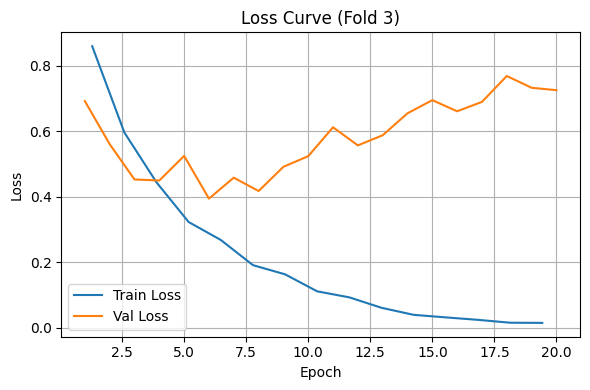

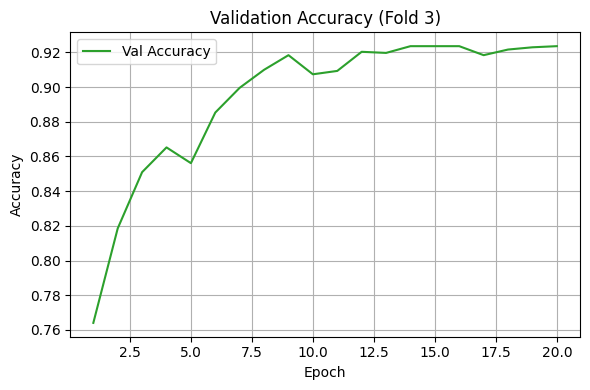

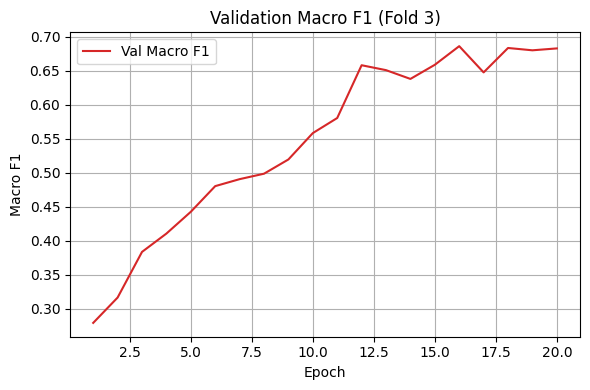

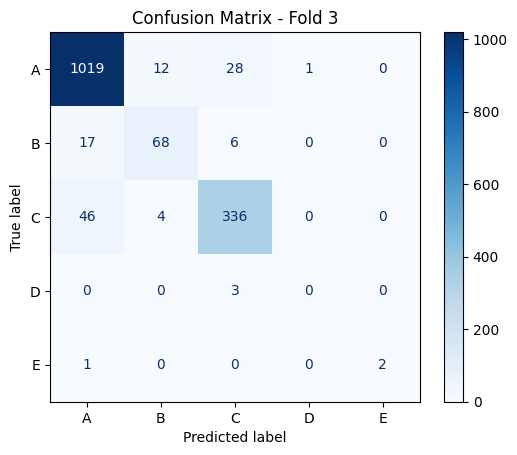

[Fold 4 / 5]


Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_46604\2173838874.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.614331,0.784187,0.295006,0.311654,0.303035
2,0.744100,0.550475,0.826312,0.477686,0.351393,0.346230
3,0.467400,0.380448,0.882696,0.478798,0.442837,0.457917
4,0.321400,0.428806,0.894362,0.589518,0.494132,0.524552
5,0.321400,0.458894,0.893065,0.501664,0.473130,0.483302
6,0.218000,0.382592,0.885936,0.463800,0.505507,0.481533
7,0.166700,0.555686,0.917045,0.527835,0.489136,0.503997
8,0.115800,0.536498,0.906027,0.731911,0.537646,0.586943
9,0.115800,0.532667,0.920933,0.742837,0.533128,0.586554
10,0.082000,0.517925,0.930006,0.697131,0.710928,0.700541


Accuracy: 0.9307 | Precision: 0.7374 | Recall: 0.7121 | F1: 0.7237
              precision    recall  f1-score      support
A              0.944904  0.970755  0.957655  1060.000000
B              0.833333  0.714286  0.769231    91.000000
C              0.908602  0.875648  0.891821   386.000000
D              0.000000  0.000000  0.000000     2.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.930655  0.930655  0.930655     0.930655
macro avg      0.737368  0.712138  0.723741  1543.000000
weighted avg   0.928160  0.930655  0.928942  1543.000000


E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


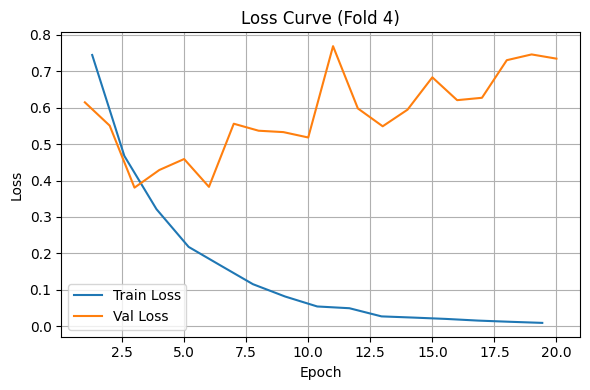

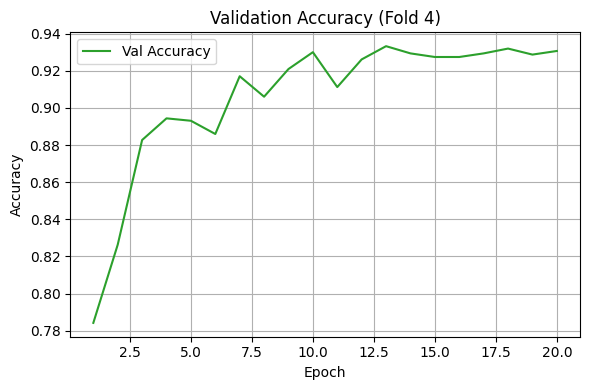

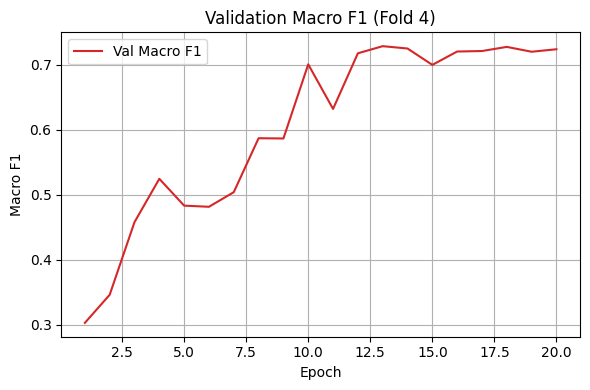

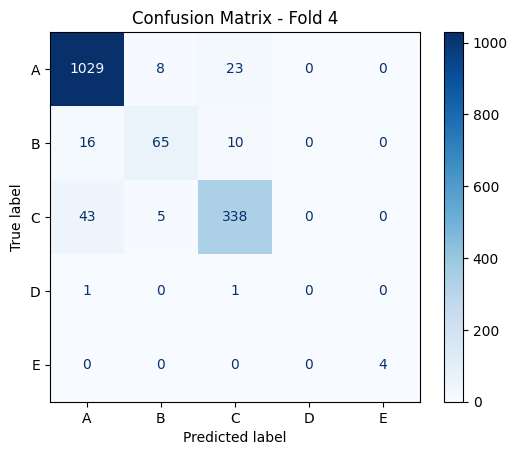

[Fold 5 / 5]


Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_46604\2173838874.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.790520,0.718730,0.269228,0.246803,0.244387
2,0.835700,0.686941,0.757615,0.303452,0.270643,0.273043
3,0.695800,0.645521,0.786779,0.297066,0.326575,0.310470
4,0.480900,0.456253,0.849644,0.332129,0.344548,0.337833
5,0.480900,0.386798,0.885936,0.513211,0.446119,0.469794
6,0.328300,0.390664,0.893065,0.480697,0.492659,0.486317
7,0.240100,0.402081,0.887881,0.480443,0.462331,0.469896
8,0.180000,0.394971,0.917045,0.534453,0.490583,0.509377
9,0.180000,0.495516,0.914452,0.731568,0.590407,0.640514
10,0.123600,0.459474,0.910564,0.600417,0.660263,0.624176


Accuracy: 0.9203 | Precision: 0.7832 | Recall: 0.7535 | F1: 0.7612
              precision    recall  f1-score      support
A              0.947075  0.962264  0.954609  1060.000000
B              0.750000  0.692308  0.720000    91.000000
C              0.885638  0.862694  0.874016   386.000000
D              0.333333  0.500000  0.400000     2.000000
E              1.000000  0.750000  0.857143     4.000000
accuracy       0.920285  0.920285  0.920285     0.920285
macro avg      0.783209  0.753453  0.761154  1543.000000
weighted avg   0.919425  0.920285  0.919640  1543.000000


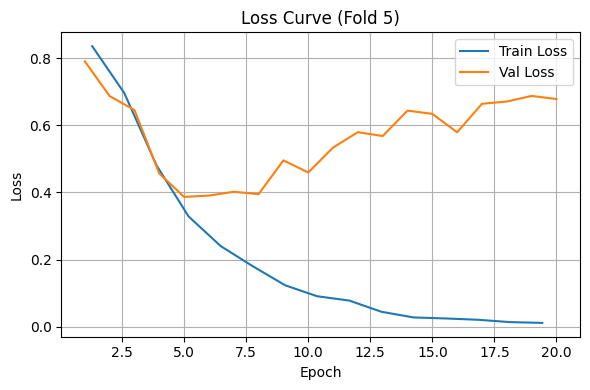

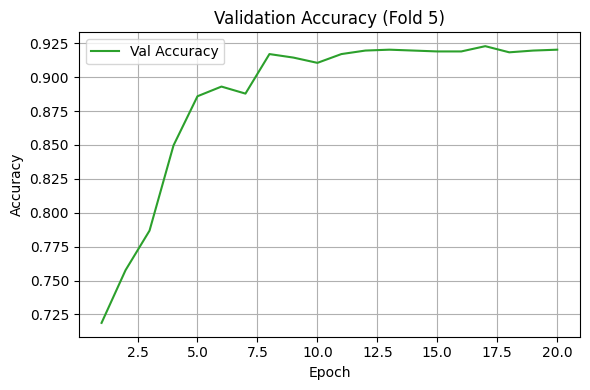

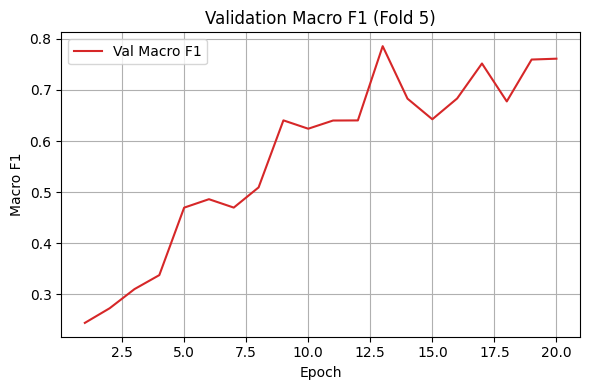

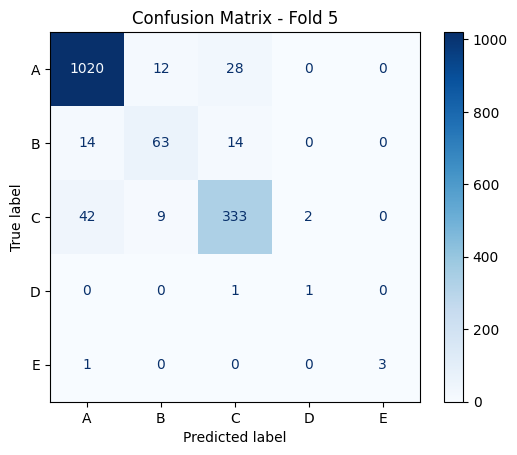

In [27]:
all_accs, all_pres, all_recs, all_f1s = [], [], [], []
all_class_f1s, all_conf_matrices = [], []
all_val_losses, all_val_accs, all_val_f1s = [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\033[34m[Fold {fold+1} / 5]\033[0m")

    # Subset 作成
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # ======================
    # 4. モデル初期化
    # ======================
    model = AutoModelForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=5,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"../models/amino-classification-transformer-vit-openai-stratified-kfold/batch-{BATCH_SIZE}-epoch-{EPOCHS}-lr-{LR}/{fold+1}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=EPOCHS,
        logging_dir="./logs",
        report_to="none",
        learning_rate=LR,
        load_best_model_at_end=False
    )

    # ======================
    # 5. 評価指標
    # ======================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        f1 = f1_score(labels, preds, average="macro")
        pre = precision_score(labels, preds, average="macro", zero_division=0)
        rec = recall_score(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1}

    # ======================
    # 6. Trainer実行
    # ======================
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # ==== ログから学習曲線抽出 ====
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.dropna(subset=["epoch"])
    train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]]
    eval_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

    all_val_losses.append(eval_loss["eval_loss"].values)
    all_val_accs.append(eval_loss["eval_accuracy"].values)
    all_val_f1s.append(eval_loss["eval_f1"].values)

    # ======================
    # 7. 推論と評価
    # ======================
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    acc = accuracy.compute(predictions=y_pred, references=y_true)["accuracy"]
    pre = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))

    report = classification_report(y_true, y_pred, target_names=list(label2id.keys()), output_dict=True)
    class_f1 = [report[c]["f1-score"] for c in list(label2id.keys())]

    # ==== 保存 ====
    all_accs.append(acc)
    all_pres.append(pre)
    all_recs.append(rec)
    all_f1s.append(f1)
    all_class_f1s.append(class_f1)
    all_conf_matrices.append(cm)

    # ==== 表示 ====
    print(f"\033[91mAccuracy: {acc:.4f}\033[0m | "
          f"\033[92mPrecision: {pre:.4f}\033[0m | "
          f"\033[93mRecall: {rec:.4f}\033[0m | "
          f"\033[94mF1: {f1:.4f}\033[0m")
    print(pd.DataFrame(report).T)

    # ==== foldごとの学習曲線を可視化 ====
    # --- Loss 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", color="C0")
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Val Loss", color="C1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Accuracy 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_accuracy"], label="Val Accuracy", color="C2")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Macro F1 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_f1"], label="Val Macro F1", color="C3")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title(f"Validation Macro F1 (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 混同行列を可視化
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

## 4. 平均可視化

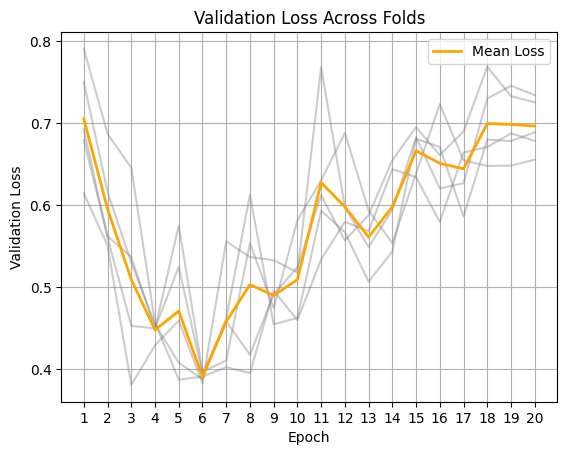

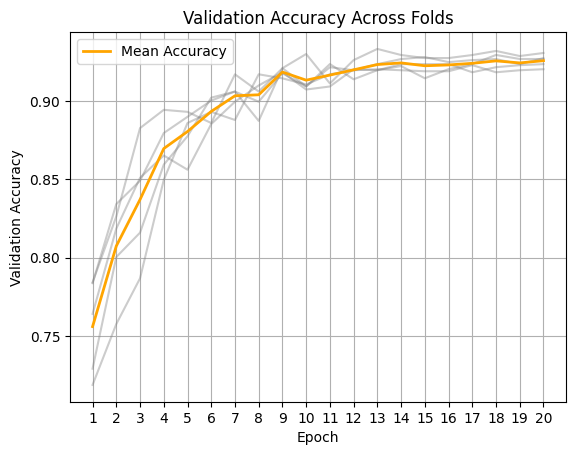

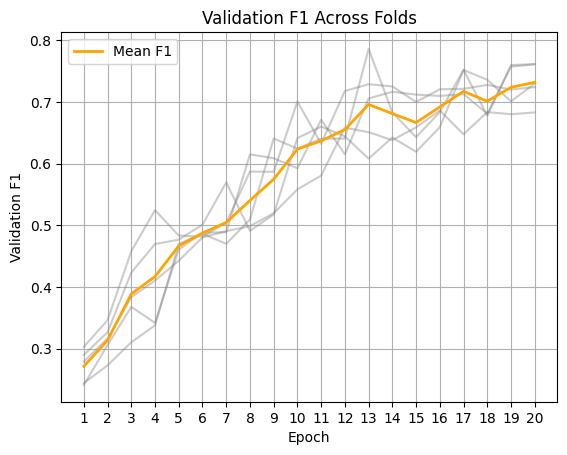

In [28]:
epochs = np.arange(1, EPOCHS + 1)

def interp_to_epochs(arr):
    arr = np.asarray(arr)
    orig_x = np.arange(1, len(arr) + 1)

    if len(arr) == 1:
        return np.full_like(epochs, arr[0], dtype=float)

    return np.interp(epochs, orig_x, arr)

def plot_mean_curves(all_vals, y_label, title, metric_name):
    interp_vals = []

    for v in all_vals:
        v_interp = interp_to_epochs(v)
        interp_vals.append(v_interp)
        plt.plot(epochs, v_interp, color="gray", alpha=0.4)

    interp_vals = np.vstack(interp_vals)
    mean_vals = interp_vals.mean(axis=0)

    plt.plot(epochs, mean_vals, color="orange", linewidth=2, label=f"Mean {metric_name}")
    plt.xlabel("Epoch"); plt.ylabel(y_label); plt.title(title)
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)
    plt.show()

plot_mean_curves(all_val_losses, "Validation Loss", "Validation Loss Across Folds", "Loss")
plot_mean_curves(all_val_accs, "Validation Accuracy", "Validation Accuracy Across Folds", "Accuracy")
plot_mean_curves(all_val_f1s, "Validation F1", "Validation F1 Across Folds", "F1")

## 5. 総合評価


===== Average Across 5 Folds =====
Accuracy : 0.9257
Precision: 0.7552
Recall   : 0.7182
F1       : 0.7315

Per-Class F1 (Macro Average):
  A: 0.9550
  B: 0.7553
  C: 0.8845
  D: 0.1600
  E: 0.9029


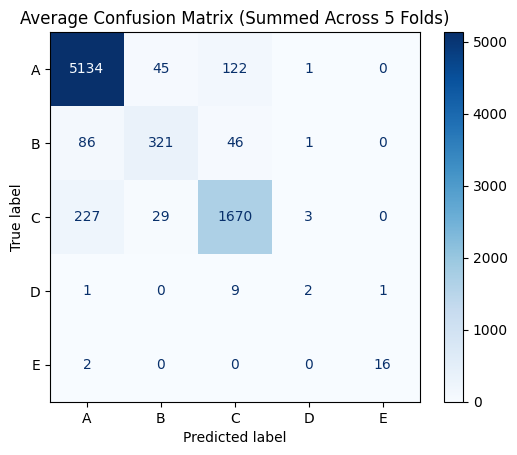

In [29]:
mean_acc = np.mean(all_accs)
mean_pre = np.mean(all_pres)
mean_rec = np.mean(all_recs)
mean_f1 = np.mean(all_f1s)
mean_class_f1 = np.mean(np.array(all_class_f1s), axis=0)

print("\n\033[36m===== Average Across 5 Folds =====\033[0m")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Precision: {mean_pre:.4f}")
print(f"Recall   : {mean_rec:.4f}")
print(f"F1       : {mean_f1:.4f}\n")

print("Per-Class F1 (Macro Average):")
for cls, score in zip(label2id.keys(), mean_class_f1):
    print(f"  {cls}: {score:.4f}")

# ==== 混同行列平均表示 ====
mean_cm = np.sum(all_conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues")
plt.title("Average Confusion Matrix (Summed Across 5 Folds)")
plt.show()